In [20]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [21]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option("display.max_colwidth", 100)

In [22]:
# Load data
train_df = pd.read_csv("../data/train_data.csv")
valid_df = pd.read_csv("../data/valid_data.csv")

train_df["text"] = train_df["text"].fillna("")
valid_df["text"] = valid_df["text"].fillna("")

In [ ]:
# Text cleaning 
def clean_financial_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # URLs
    text = re.sub(r"http\S+|www\.\S+|https\S+", "", text)

    # Mentions
    text = re.sub(r"@\w+", "", text)

    # HTML entities
    text = re.sub(r"&\w+;", " ", text)

    # Keep letters, numbers, spaces, $, %, dots, commas
    text = re.sub(r"[^a-z0-9\s\$\%\.\,]", " ", text)

    # Normalize stock tickers: "$ aapl" -> "$aapl"
    text = re.sub(r"\$\s+([a-z]+)", r"$\1", text)

    # Normalize percentages: "10  %" -> "10%"
    text = re.sub(r"(\d+)\s*%", r"\1%", text)

    text = re.sub(r"\s+", " ", text).strip()
    return text

In [24]:
# Apply preprocessing
train_df["clean_text"] = train_df["text"].apply(clean_financial_text)
valid_df["clean_text"] = valid_df["text"].apply(clean_financial_text)

# Drop any empty texts
train_df = train_df[train_df["clean_text"].str.len() > 0].reset_index(drop=True)
valid_df = valid_df[valid_df["clean_text"].str.len() > 0].reset_index(drop=True)

In [25]:
# Tokenization
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 128
OOV_TOKEN = "<OOV>"

# Same custom filters as original
custom_filters = '!"#&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token=OOV_TOKEN,
    filters=custom_filters,
)

tokenizer.fit_on_texts(train_df["clean_text"])
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_valid_seq = tokenizer.texts_to_sequences(valid_df["clean_text"])

X_train = pad_sequences(
    X_train_seq, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post"
)
X_valid = pad_sequences(
    X_valid_seq, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post"
)

y_train = train_df["label"].values
y_valid = valid_df["label"].values

NUM_CLASSES = 20  # same as original


In [ ]:
# Class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train,
)
class_weights_dict = dict(enumerate(class_weights_array))


In [ ]:
# BiLSTM model
def build_bilstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential(
        [
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=max_length,
                name="embedding",
            ),
            SpatialDropout1D(0.3, name="spatial_dropout"),
            Bidirectional(
                LSTM(
                    128,
                    return_sequences=False,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    kernel_regularizer=l2(0.001),
                ),
                name="bidirectional_lstm",
            ),
            BatchNormalization(name="batch_norm_1"),
            Dense(128, activation="relu", kernel_regularizer=l2(0.001), name="dense_1"),
            Dropout(0.5, name="dropout_1"),
            Dense(64, activation="relu", kernel_regularizer=l2(0.001), name="dense_2"),
            Dropout(0.3, name="dropout_2"),
            Dense(num_classes, activation="softmax", name="output"),
        ]
    )
    return model


model = build_bilstm_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQ_LENGTH,
    num_classes=NUM_CLASSES,
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [28]:
# Training
BATCH_SIZE = 64
EPOCHS = 30

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1,
)


Epoch 1/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 46s 160ms/step - accuracy: 0.1728 - loss: 2.9850 - val_accuracy: 0.4111 - val_loss: 2.9664 - learning_rate: 0.0010
Epoch 2/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.4560 - loss: 1.7138 - val_accuracy: 0.6084 - val_loss: 1.8519 - learning_rate: 0.0010
Epoch 3/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.6030 - loss: 1.2002 - val_accuracy: 0.6659 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 4/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.7323 - loss: 0.8442 - val_accuracy: 0.7055 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 5/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.7936 - loss: 0.6903 - val_accuracy: 0.7318 - val_loss: 1.3198 - learning_rate: 0.0010
Epoch 6/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.8404 - loss: 0.5942 - val_accuracy: 0.7437 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 7/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.84

In [29]:
# Predictions and metrics
y_pred_probs = model.predict(X_valid, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_valid, y_pred)
f1_macro = f1_score(y_valid, y_pred, average="macro")
f1_weighted = f1_score(y_valid, y_pred, average="weighted")
precision_macro = precision_score(y_valid, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_valid, y_pred, average="macro", zero_division=0)

print("\nEvaluation metrics:")
print(f"  Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  F1 (macro):         {f1_macro:.4f}")
print(f"  F1 (weighted):      {f1_weighted:.4f}")
print(f"  Precision (macro):  {precision_macro:.4f}")
print(f"  Recall (macro):     {recall_macro:.4f}")

print("\nClassification report:")
print(classification_report(y_valid, y_pred, digits=4, zero_division=0))



Evaluation metrics:
  Accuracy:           0.7318 (73.18%)
  F1 (macro):         0.7204
  F1 (weighted):      0.7346
  Precision (macro):  0.6875
  Recall (macro):     0.7893

Classification report:
              precision    recall  f1-score   support

           0     0.5443    0.5890    0.5658        73
           1     0.8619    0.8458    0.8538       214
           2     0.8569    0.5059    0.6362       852
           3     0.4196    0.7792    0.5455        77
           4     0.9495    0.9691    0.9592        97
           5     0.9150    0.9339    0.9243       242
           6     0.6406    0.8425    0.7278       146
           7     0.7374    0.9125    0.8156       160
           8     0.6667    0.9375    0.7792        32
           9     0.7904    0.6418    0.7084       335
          10     0.5500    0.8462    0.6667        13
          11     0.3478    0.5714    0.4324        14
          12     0.7609    0.8824    0.8171       119
          13     0.5155    0.7155    0.5993 

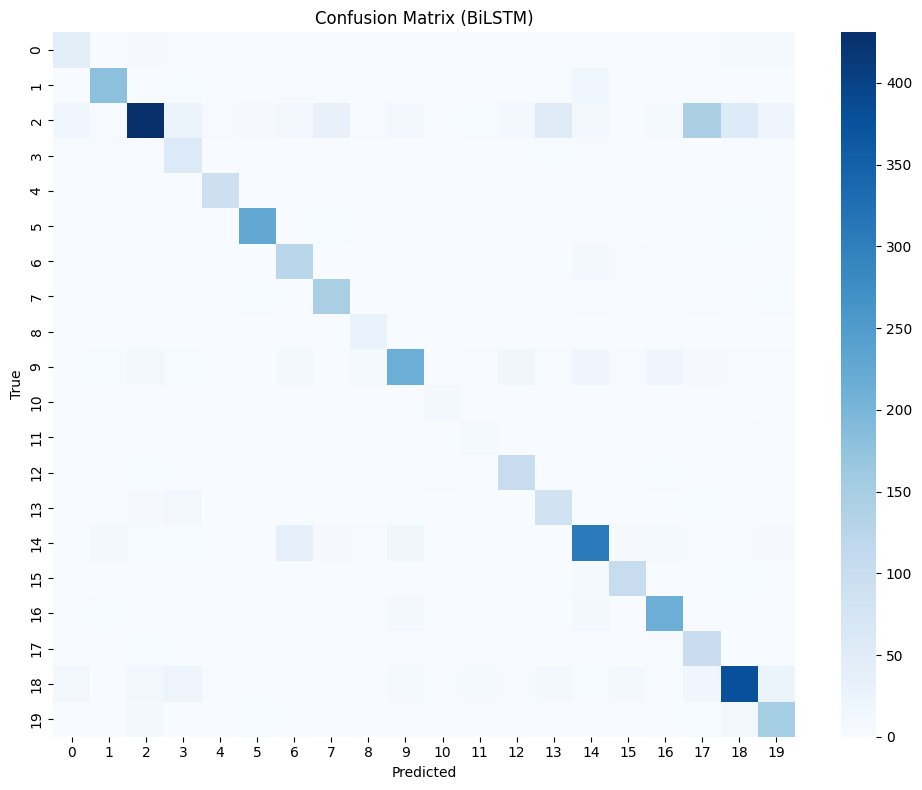

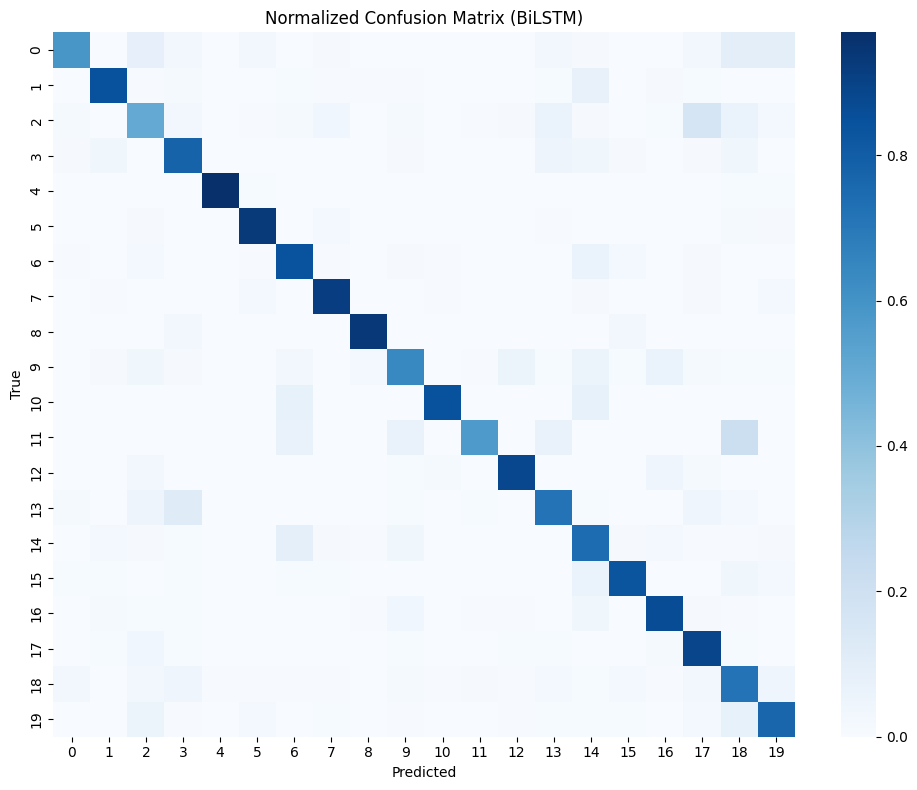

In [30]:
# Confusion matrix (raw + normalized)
cm = confusion_matrix(y_valid, y_pred)
cm_normalized = confusion_matrix(y_valid, y_pred, normalize="true")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (BiLSTM)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=False, cmap="Blues", fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (BiLSTM)")
plt.tight_layout()
plt.show()


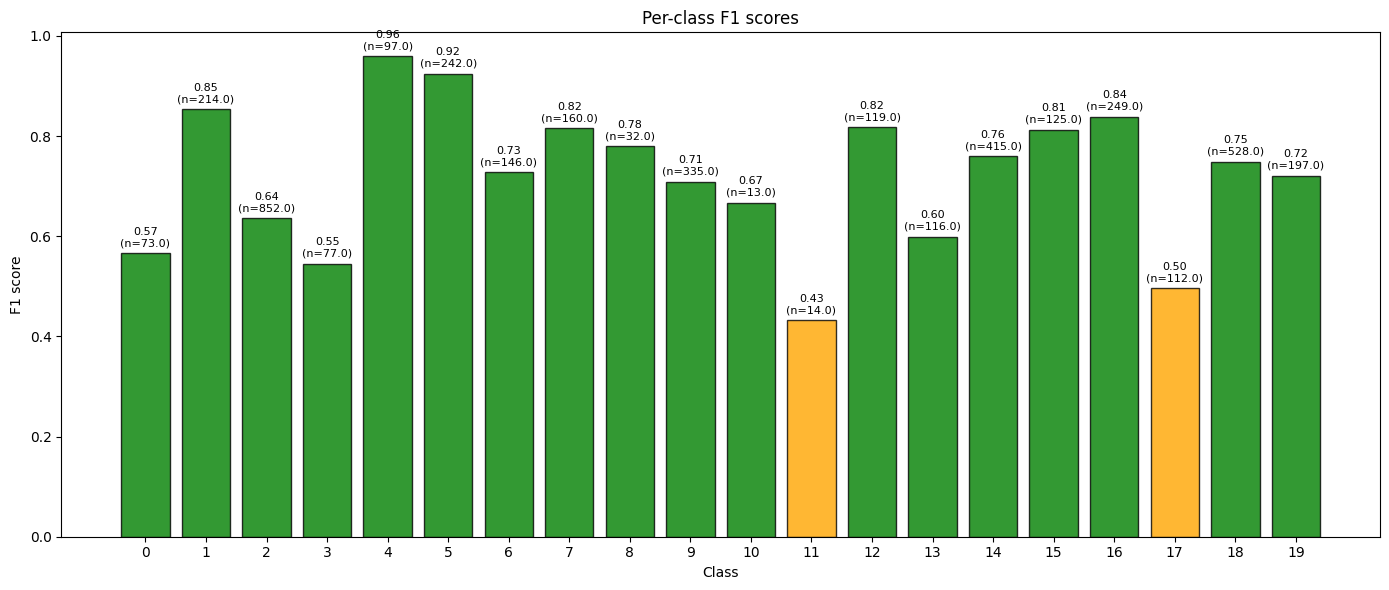

In [31]:
# Per-class F1 bar chart (same logic)
report_dict = classification_report(
    y_valid, y_pred, output_dict=True, zero_division=0
)

f1_scores = [report_dict[str(i)]["f1-score"] for i in range(NUM_CLASSES)]
supports = [report_dict[str(i)]["support"] for i in range(NUM_CLASSES)]

fig, ax = plt.subplots(figsize=(14, 6))

colors = [
    "green" if f1 >= 0.5 else "orange" if f1 >= 0.3 else "red" for f1 in f1_scores
]
bars = ax.bar(range(NUM_CLASSES), f1_scores, color=colors, edgecolor="black", alpha=0.8)

for i, (bar, f1, sup) in enumerate(zip(bars, f1_scores, supports)):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{f1:.2f}\n(n={sup})",
        ha="center",
        va="bottom",
        fontsize=8,
    )

ax.set_xlabel("Class")
ax.set_ylabel("F1 score")
ax.set_title("Per-class F1 scores")
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(range(NUM_CLASSES))
plt.tight_layout()
plt.show()


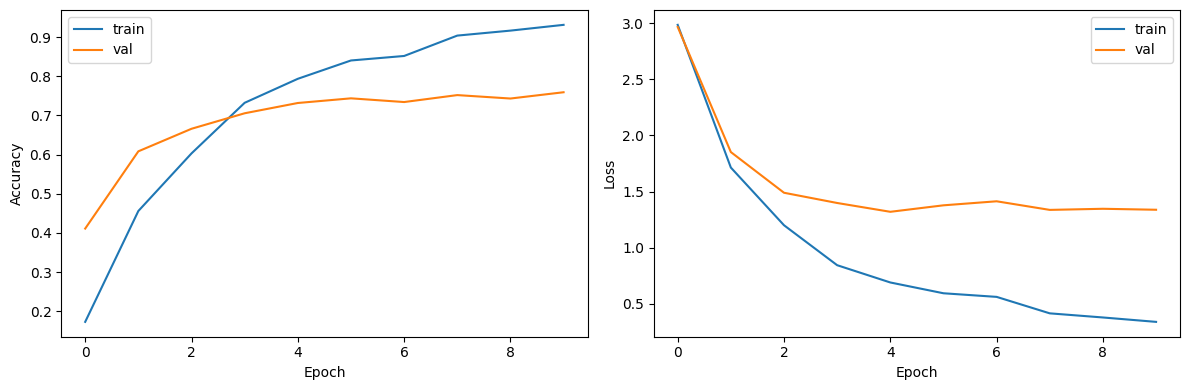

In [33]:
# Training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
